<a href="https://colab.research.google.com/github/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/notebooks/Week_4/Week_4_Lecture_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 6: Gradient Descent and Variants Part 2 <sup><mark style="background-color:gold">Code</mark> </sup>

In [182]:
#@title 
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"g_bV6bo5dL0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)
display(out1)

Output()

In [183]:
#@title 
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Slides/Week_4/DL4CV_Week04_Part03.pdf" target="_blank">
    <img src="https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Data/Slides_Logo.png?raw=1"
  alt="button link to Airtable" style="width:200px"></a>
    </div>""" )

## Gradient Descent Variants

### Pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. Let’s first create an example surface of this and visualize it:

In [184]:
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [185]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

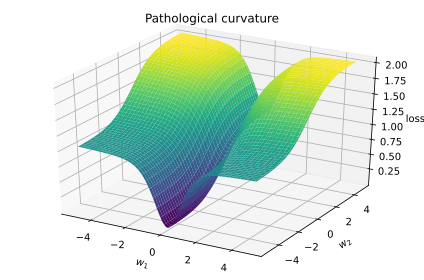

In [186]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = fig.gca(projection='3d') if plot_3d else fig.gca()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y])
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [187]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [188]:
SGD_points = train_curve(lambda params: torch.optim.SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: torch.optim.SGD(params, lr=10, momentum=0.9))
Nest_points = train_curve(lambda params: torch.optim.SGD(params, lr=10, momentum=0.9,nesterov=True))
Adagrad_points = train_curve(lambda params: torch.optim.Adagrad(params, lr=10))
RMSprop_points = train_curve(lambda params: torch.optim.RMSprop(params, lr=10,alpha = 0.1))
Adam_points = train_curve(lambda params: torch.optim.Adam(params, lr=10))

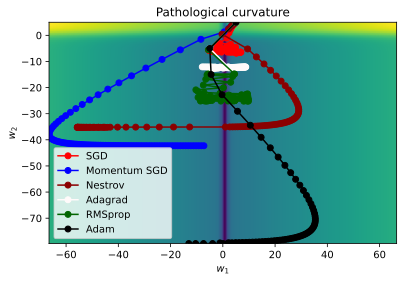

In [189]:
all_points = np.concatenate([SGD_points, SGDMom_points, Nest_points, Adagrad_points,RMSprop_points,Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o",  label="Momentum SGD")
ax.plot(Nest_points[:,0], Nest_points[:,1], color="darkred", marker="o",  label="Nestrov")
ax.plot(Adagrad_points[:,0], Adagrad_points[:,1], color="snow", marker="o",  label="Adagrad")
ax.plot(RMSprop_points[:,0], RMSprop_points[:,1], color="darkgreen", marker="o",  label="RMSprop")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="black", marker="o", label="Adam")
plt.legend()
plt.show()

### Steep optima
A second type of challenging loss surfaces are steep optima. In those, we have a larger part of the surface having very small gradients while around the optimum, we have very large gradients. For instance, take the following loss surfaces:

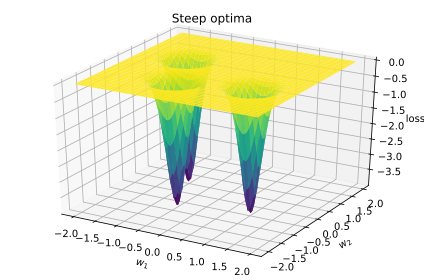

In [190]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

In [191]:
SGD_points = train_curve(lambda params: torch.optim.SGD(params, lr=0.05),comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: torch.optim.SGD(params, lr=0.05, momentum=0.9),comb_func, init=[0,0])
Nest_points = train_curve(lambda params: torch.optim.SGD(params, lr=0.05, momentum=0.9,nesterov=True),comb_func, init=[0,0])
Adagrad_points = train_curve(lambda params: torch.optim.Adagrad(params, lr=0.05),comb_func, init=[0,0])
RMSprop_points = train_curve(lambda params: torch.optim.RMSprop(params, lr=0.05,alpha = 0.1),comb_func, init=[0,0])
Adam_points = train_curve(lambda params: torch.optim.Adam(params, lr=0.05),comb_func, init=[0,0])

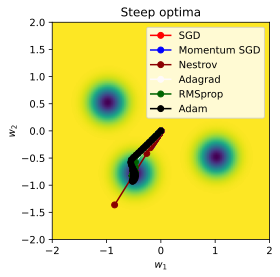

In [192]:
all_points = np.concatenate([SGD_points, SGDMom_points, Nest_points, Adagrad_points,RMSprop_points,Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o",label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", label="Momentum SGD")
ax.plot(Nest_points[:,0], Nest_points[:,1], color="darkred", marker="o",  label="Nestrov")
ax.plot(Adagrad_points[:,0], Adagrad_points[:,1], color="snow", marker="o", label="Adagrad")
ax.plot(RMSprop_points[:,0], RMSprop_points[:,1], color="darkgreen", marker="o", label="RMSprop")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="black", marker="o", label="Adam")
plt.legend()
plt.show()

**Acknowledgement**

Code adopted from the University of Amsterdam's Deep Learning course

https://uvadlc-notebooks.readthedocs.io/en/latest/index.html